In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from sklearn.linear_model import LinearRegression
import numpy as np

sns.set_context("talk")

# Estimate Forward Times Using ITLs

In [2]:
# median ITLs
# data comes from ./results2/
itlk1 = 26.81
itlk2 = 29.60
itlk3 = 31.69
itlk4 = 34.34
itlk5 = 36.89
itlk6 = 39.37
itlk7 = 41.39
itlk8 = 44.70
itls = [itlk1, itlk2, itlk3, itlk4, itlk5, itlk6, itlk7, itlk8]
xs = list(range(1, len(itls) + 1))
len(itls), len(xs)

(8, 8)

In [3]:
reg = LinearRegression()
reg = reg.fit(np.array(xs)[:, None], itls)
fwd_32b = reg.intercept_.item()
fwd_1_7b = reg.coef_.item()
fwd_32b, fwd_1_7b

(24.36107142857142, 2.497261904761905)

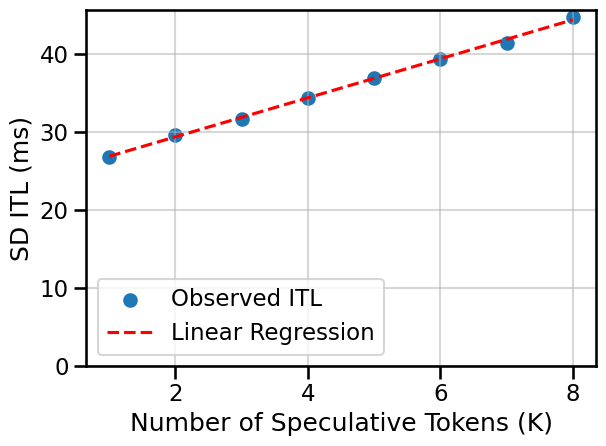

In [4]:
plt.scatter(xs, itls, marker="o", label="Observed ITL")
plt.ylim(0, None)
plt.grid(alpha=0.5)
plt.xlabel("Number of Speculative Tokens (K)")
plt.ylabel("SD ITL (ms)")

# Add linear regression line
x_vals = np.linspace(min(xs), max(xs), 100)
y_pred = reg.predict(x_vals[:, None])
plt.plot(x_vals, y_pred, color="red", linestyle="--", label="Linear Regression")

plt.legend()
plt.tight_layout()
plt.savefig("imgs/itl_k_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
# Thesee are TPOT values without SD
# They are independent of K, and show feasible lower bounds for forward times
tpot_1_7b = 2.27
tpot_32b = 23.65

What kind of speedups should be obvserve from SD?
For $K=4$, we execute the drafter 4 times, and the target 1 time.
And because of token rejections, we get a number of token equivalent to the acceptance length (AL)

$$T_{s} = \frac{K \cdot T_{d} + T_{t}}{AL} = \frac{ITL}{AL} $$

In [6]:
k = 4
expected_sd_itl = k * tpot_1_7b + tpot_32b
al = 3.28
expected_sd_tpot = expected_sd_itl / al
expected_sd_tpot

9.978658536585366

What are the current speedups?
We compare TPOT in SD to non-SD.

In [7]:
actual_sd_tpot = 10.46  # Median TPOT, SD K=4
actual_speedup = tpot_32b / actual_sd_tpot
actual_speedup

2.260994263862332

What should be the speedup?

In [8]:
expected_speedup = tpot_32b / expected_sd_tpot
expected_speedup

2.370058050717996

# Optimal K
Would K=4 still be optimal?
The analysis below show that the optimal K (to maximize TPOT) should be 5 to 6.

In [9]:
# from k=3 to k=8
al1 = 1.80
al2 = 2.40
al3 = 2.87
al4 = 3.28
al5 = 3.53
al6 = 3.70
al7 = 3.90
al8 = 4.04
acceptance_lens = torch.tensor([al1, al2, al3, al4, al5, al6, al7, al8])

In [10]:
def sd_tpot(k, tpot_1_7b, tpot_32b):
    itl = tpot_1_7b * k + tpot_32b
    # starts at k=1, so k=1 -> idx=0
    al = acceptance_lens[idx := k - 1]
    return itl / al


sd_tpot(4, tpot_1_7b=tpot_1_7b, tpot_32b=tpot_32b), torch.tensor(expected_sd_tpot)

(tensor(9.9787), tensor(9.9787))

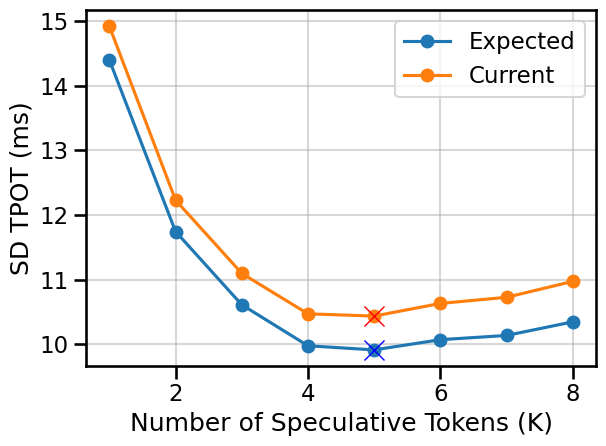

In [11]:
k_values = torch.arange(1, 9)
expected_tpot_values = torch.tensor(
    [sd_tpot(k, tpot_1_7b=tpot_1_7b, tpot_32b=tpot_32b) for k in k_values]
)
actual_tpot_values = torch.tensor(
    [sd_tpot(k, tpot_1_7b=fwd_1_7b, tpot_32b=fwd_32b) for k in k_values]
)

plt.plot(k_values, expected_tpot_values, label="Expected", marker="o")
plt.plot(
    k_values[expected_tpot_values.argmin()],
    expected_tpot_values.min(),
    marker="x",
    color="blue",
    markersize=15,
)
plt.plot(k_values, actual_tpot_values, label="Current", marker="o")
plt.plot(
    k_values[actual_tpot_values.argmin()],
    actual_tpot_values.min(),
    marker="x",
    color="red",
    markersize=15,
)
plt.xlabel("Number of Speculative Tokens (K)")
plt.ylabel("SD TPOT (ms)")

plt.tight_layout()
plt.grid(alpha=0.5)
plt.legend()

os.makedirs("imgs", exist_ok=True)
plt.savefig("imgs/tpot_k_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
best_expected_tpot_sd = expected_tpot_values.min()
best_expected_speedup = tpot_32b / best_expected_tpot_sd
best_expected_speedup

tensor(2.3853)

In [13]:
best_expected_speedup / actual_speedup

tensor(1.0550)

In [14]:
fwd_1_7b / tpot_1_7b

1.1001153765470946

* The draft model (Qwen3-1.7B) runs decodes faster when its the main model (TPOT of 2.27ms vs 2.50ms).
* Implementing full CUDA graphs for the draft model would speed up this drafter by 10%.
* However, since the drafter only makes a fraction of the total runtime, the TPOT improvement would be closer to 5% to 6%.
* This assumes that the forward of pass of the target model is also optimized (down from 24.36 to 23.65ms), otherwise the e2e speedup is between 3 to 4%.


In [15]:
actual_tpot_values.min(), expected_tpot_values.min()


(tensor(10.4384), tensor(9.9150))